In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from dotenv import load_dotenv
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer,
    classification_report,
    log_loss,
)

In [40]:
from cltk.alphabet.grc import normalize_grc
from lexicogenero.ferramentas.diorisis_reader import (
    carrega_textos,
    em_pandas,
    sent_pandas,
)
from lexicogenero.ferramentas.data import gera_hist_filo, gera_paragrafo, gera_sent
from lexicogenero.grc import STOPS_LIST

In [41]:
# Carrega path para o Diorisis a depender do especificado em ../.env,
# rompe runtime caso não esteja especificada.
load_dotenv()
DIORISIS_PATH = os.getenv("DIORISIS_PATH")
assert DIORISIS_PATH is not None, "Path para DIORISIS não especificada"

Opções gráficas

In [42]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.style.use("ggplot")
sns.set_palette("Dark2")

Geração de banco de dados

In [43]:
DATA = "./data/data_classico.csv"
SENTS = "./data/sents_classico.csv"
if os.path.exists(DATA) and os.path.exists(SENTS):
    print(f"Carregando arquivos:\n\t{DATA}\n\t{SENTS}")
    logging.info(f"Carregando arquivos:\n\t{DATA}\n\t{SENTS}")
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(SENTS)
else:
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
            "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
        "Plato (0059) - Lovers (016).json",  # Espúrios
        "Plato (0059) - Epistles (036).json",
        "Plato (0059) - Alcibiades 1 (013).json",
        "Plato (0059) - Alcibiades 2 (014).json",  # Anotação problemática
        "Plato (0059) - Cleitophon (029).json",
        "Plato (0059) - Epinomis (035).json",
        "Plato (0059) - Hipparchus (015).json",
        "Plato (0059) - Menexenus (028).json",
        "Plato (0059) - Minos (033).json",
        "Plato (0059) - Theages (017).json",
    ]

    corpus = carrega_textos(
        autores=[
            "Herodotus",
            "Thucydides",
            "Plato",
            "Xenophon (0032)",  # Exclui Xenofonte de Éfeso
        ],
        diorisis_path=DIORISIS_PATH,
        ignore=ignorados,
        verbose=False,
    )

    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)

Carregando arquivos:
	./data/data_classico.csv
	./data/sents_classico.csv


In [44]:
df_tokens.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories


In [45]:
df_sents.head()

,sent_id,location,forms,lemmata,file,author,text
0,1,1.t.1,"Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ,...",Ἡρόδοτος Ἁλικαρνησσεύς ἱστορία ἀπόδεξις ὅδε ὡς...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,2,1.1.1,Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασ...,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,3,1.1.2,τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσση...,οὗτος γάρ ἀπό ὁ Ἐρυθραί καλέω θάλασσα ἀφικνέομ...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,4,1.1.7,τὸ δὲ Ἄργος τοῦτον τὸν χρόνον προεῖχε ἅπασι τῶ...,ὁ δέ Ἄργος οὗτος ὁ χρόνος προέχω ἅπας ὁ ἐν ὁ ν...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,5,1.1.9,ἀπικομένους δὲ τούς Φοίνικας ἐς δὴ τὸ Ἄργος το...,ἀφικνέομαι δέ ὁ Φοῖνιξ εἰς δή ὁ Ἄργος οὗτος δι...,Herodotus (0016) - Histories (001).json,Herodotus,Histories


In [46]:
df_tokens.dropna(inplace=True)
df_sents.dropna(inplace=True)

In [47]:
df_sents["lemmata"] = df_sents["lemmata"].apply(normalize_grc)
df_tokens["lemma"] = df_tokens["lemma"].apply(normalize_grc)

In [48]:
lst_hist = [
    "Herodotus (0016) - Histories (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
    "Thucydides (0003) - History (001).json",
]
df_tokens = gera_hist_filo(df_tokens, lst_hist)
df_sents = gera_hist_filo(df_sents, lst_hist)

`TODO:` É necessário reimplementar as funções `gera_sent`, `gera_tokens` e `gera_paragrafo`.

In [49]:
df_verbos = df_tokens.loc[
        (df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST)),
]

In [52]:
df_verbos_sent = gera_sent(df_verbos)

In [53]:
df_verbos_par = gera_paragrafo(df_verbos)

/home/caiog/proj/2023sbec/dados/lexicogenero/src/lexicogenero/ferramentas/data.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["div_sup", "par"]] = data.location.str.split(".", n=1, expand=True)
/home/caiog/proj/2023sbec/dados/lexicogenero/src/lexicogenero/ferramentas/data.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [ ]:
df_subst = df_tokens.loc[(df_tokens.POS == "noun") & (-df_tokens.lemma.isin(STOPS_LIST)),]
df_subst_sent = gera_sent(df_subst)
df_subst_par = gera_paragrafo(df_subst)
df_tokens_par = gera_paragrafo(df_tokens.loc[df_tokens.POS != "punct"])

In [24]:
df_verbos.location.str.split(".", n=1, expand=True).rename({0: "div_sup", 1:"par"}, axis=1)

,div_sup,par
9,1,t.1
15,1,t.1
30,1,t.1
33,1,t.1
42,1,t.1
...,...,...
1263086,9,7.1
1263094,9,7.4
1263102,9,7.4
1263103,9,7.4


## Preparação de modelo

In [14]:
x_dpv, y_dpv = df_verbos_par.lemma, df_verbos_par.genero

In [15]:
    print("Treinando modelo de uso")
    logging.info("Treinando modelo de uso")
    verbos_dgci = set(
        [
            normalize_grc(x)
            for x in [
                "ἀνίημι",
                "δέομαι",
                "δοκέω",
                "ἐγχωρέω",
                "ἐκγίγνομαι",
                "ἔνειμι",
                "ἐντέλλω",
                "ἔοικα",
                "ἔξεστι",
                "ἐπαγγέλλω",
                "ἐπαινέω",
                "ἐπιβάλλω",
                "ἐπισκήπτω",
                "ἐπιτάσσω",
                "ἐπιτέλλω",
                "ἐπαινέω",
                "ἱκετεύω",
                "καταδικάζω",
                "κηρύσσω",
                "παραγγέλλω",
                "παραιτέω",
                "παραιτέομαι",
                "παραμυθέομαι",
                "παρίημι",
                "πιστεύω",
                "πόρω",
                "πρέπει",
                "πρέπω",
                "προβάλλω",
                "προξενέω",
                "προσδέομαι",
                "προσήκει",
                "προστάσσω",
                "προσχρῄζω",
                "προτίθημι",
                "σημαίνω",
                "συγγιγνώσκω",
                "συμβαίνω",
                "συμβουλεύω",
                "συμπίπτω",
                "ὑπάρχω",
                "ὐφίημι",
                "χρῄζω",
                "χρῄζω",
                "ὑπάρχω",
                "ἐπισκήπτω",
                "παραγγέλλω",
                "ἐγχωρέω",
                "προσήκω",
                "συμβουλεύω",
                "ἐξαρκέω",
                "ἔξεστι",
                "συμφέρω",
                "ἀφίημι",
                "δίδωμι",
                "δέομαι",
                "δοκέω",
                "ἐντέλλω",
            ]
        ]
    )

    pipe = Pipeline(
        steps=[
            (
                "vectorizer",
                TfidfVectorizer(ngram_range=(1, 1),
                                stop_words=STOPS_LIST, binary=True),
            ),
            ("bayes", MultinomialNB()),
        ]
    )

    x_treino, x_teste, y_treino, y_teste = train_test_split(
        x_dpv, y_dpv, test_size=0.2, shuffle=True, random_state=169
    )

    pipe.fit(x_treino, y_treino)

    vectorizer: Any = pipe["vectorizer"]
    bayes: Any = pipe["bayes"]

    y_pred = pipe.predict_proba(x_treino)

    print(classification_report(y_pred=pipe.predict(x_teste), y_true=y_teste))
    logging.info(classification_report(
        y_pred=pipe.predict(x_teste), y_true=y_teste))
    print(
        f"log loss: {log_loss(y_true=y_treino, y_pred=y_pred, labels=['filo', 'hist'])}"
    )
    logging.info(
        f"log loss: {log_loss(y_true=y_treino, y_pred=y_pred, labels=['filo', 'hist'])}"
    )

Treinando modelo de uso
              precision    recall  f1-score   support

        hist       0.81      0.76      0.79      4696
         nan       0.79      0.84      0.82      5136

    accuracy                           0.80      9832
   macro avg       0.80      0.80      0.80      9832
weighted avg       0.80      0.80      0.80      9832

log loss: 1.460656685104139


/home/caiog/.cache/pypoetry/virtualenvs/lexicogenero-7rVxpKCr-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/caiog/.cache/pypoetry/virtualenvs/lexicogenero-7rVxpKCr-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


<AxesSubplot:>

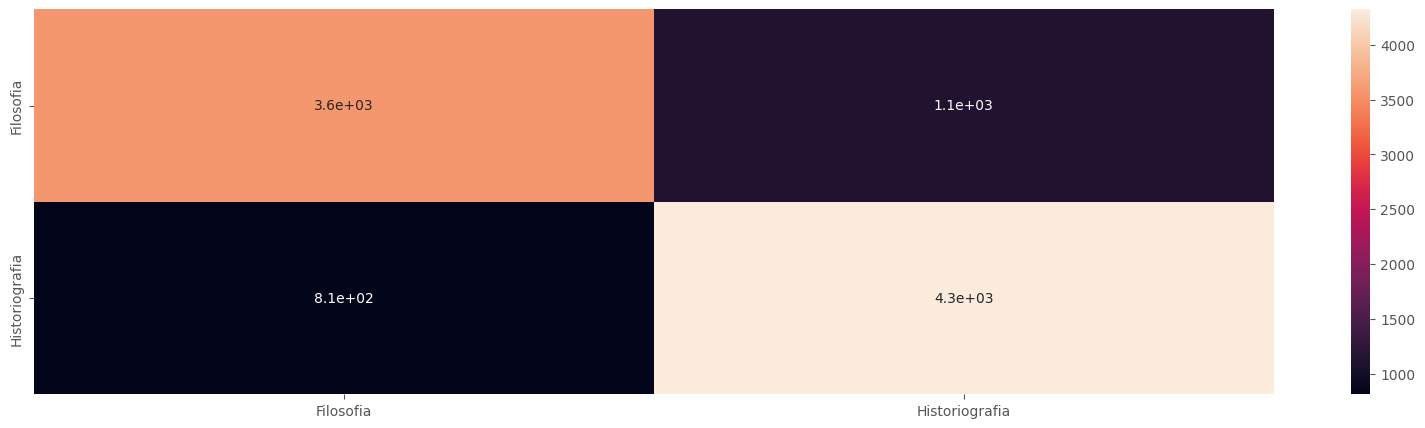

In [16]:
cm = pd.DataFrame(confusion_matrix(y_pred=pipe.predict(x_teste), y_true=y_teste))
cm.rename({0: "Filosofia", 1: "Historiografia"}, inplace=True)
cm.rename({0: "Filosofia", 1: "Historiografia"}, axis=1, inplace=True)
sns.heatmap(cm, annot=True)

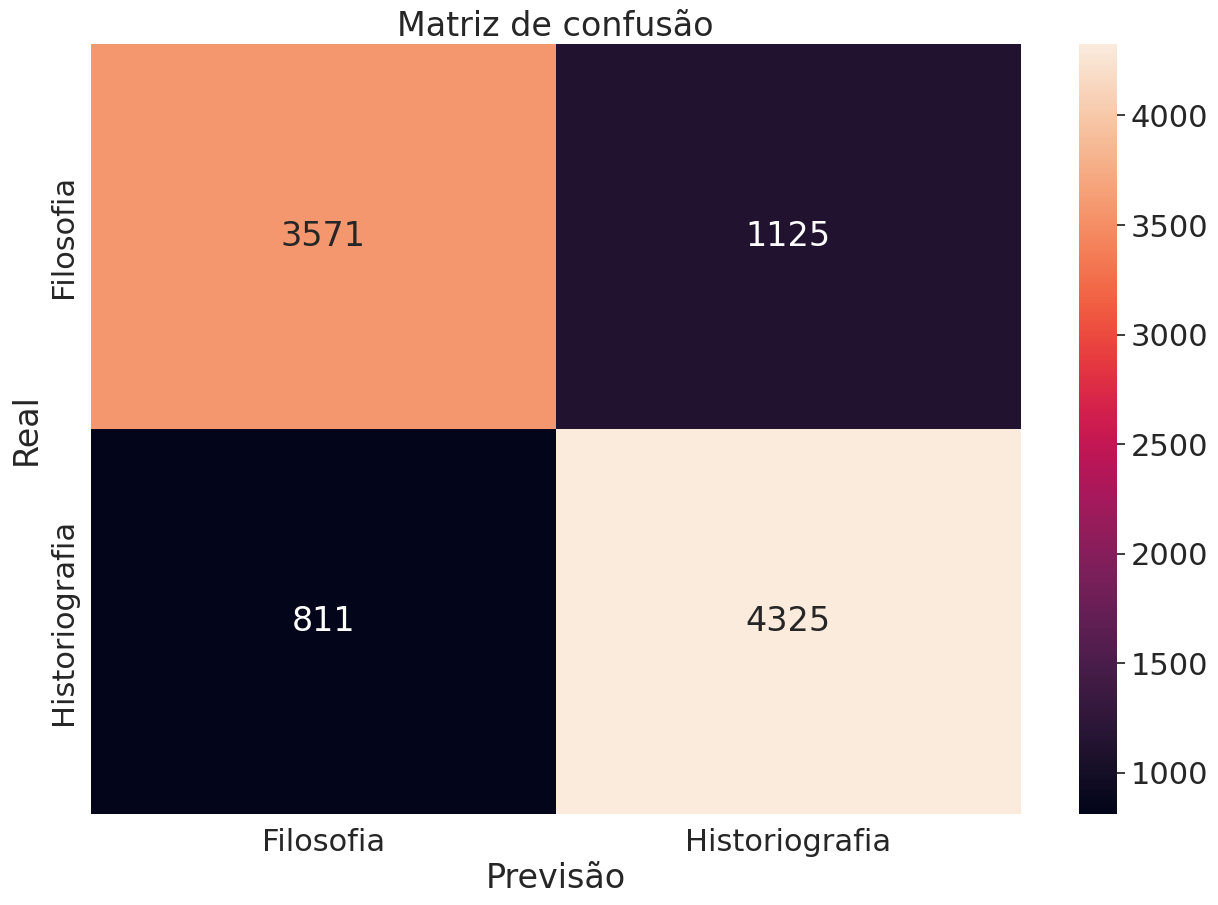

In [17]:
    plt.figure(figsize=(15, 10))
    sns.set(font_scale=2)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
    )
    plt.title("Matriz de confusão")
    plt.ylabel("Real")
    plt.xlabel("Previsão")
    plt.savefig(
        "./figs/confusao.png",
        bbox_inches="tight",
    )

Salvando resultados em ./data/data_flp.csv
Salvando resultados em ./data/data_diff.csv


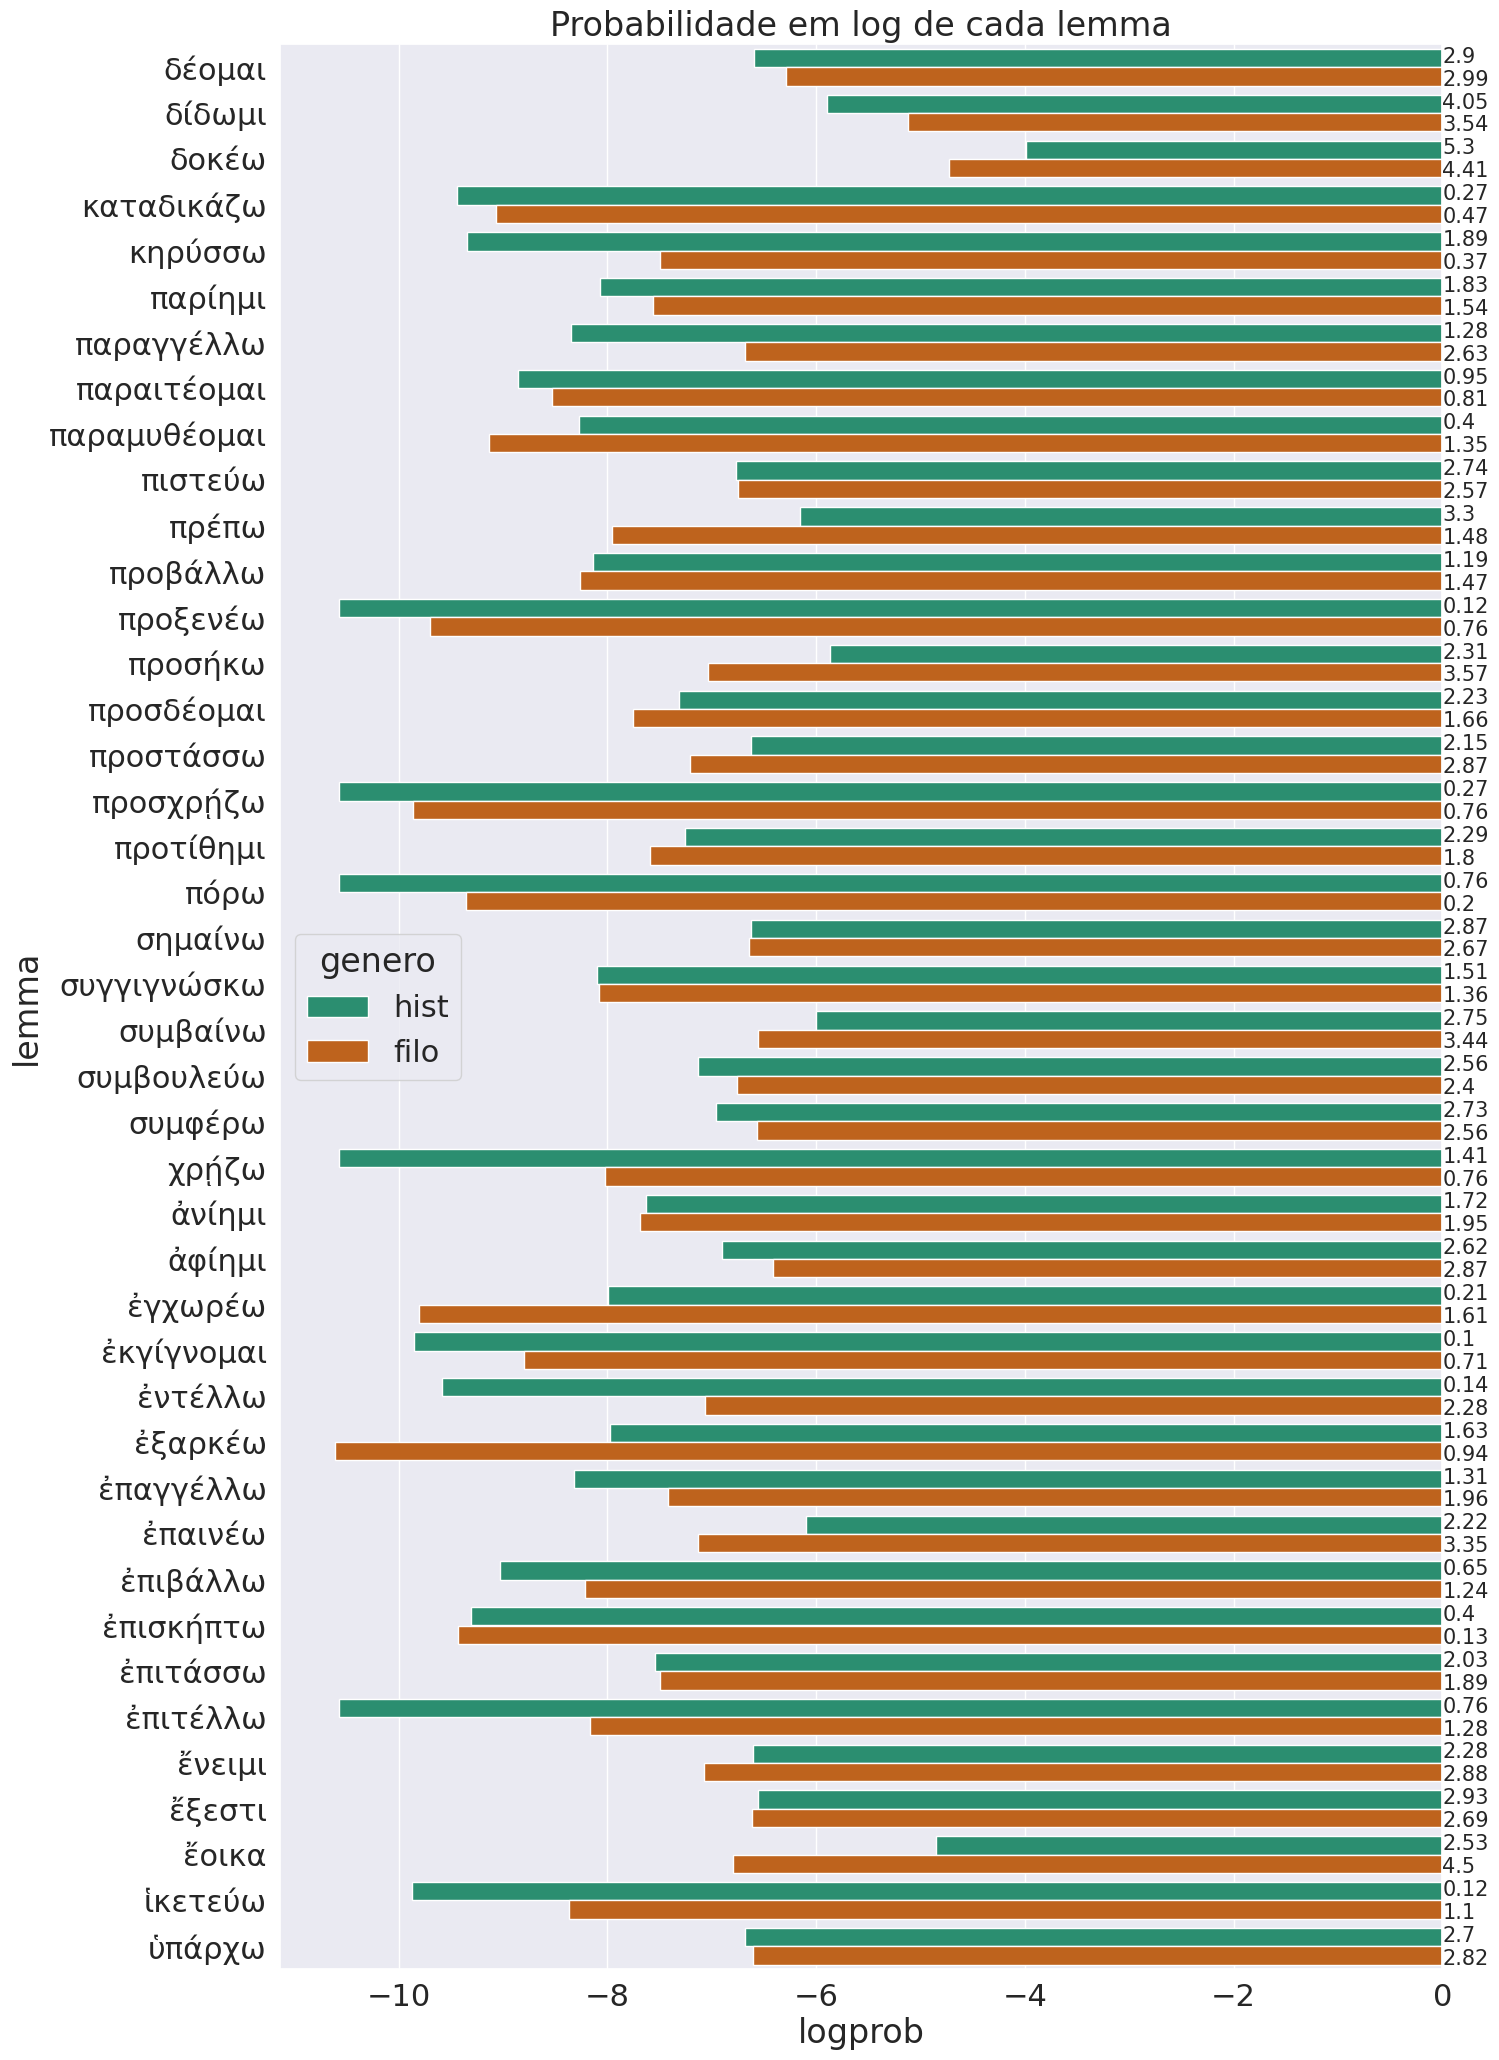

In [18]:
    feature_log_prob_hist: Dict[str, float] = {}
    for ngram, index in vectorizer.vocabulary_.items():
        feature_log_prob_hist[ngram] = bayes.feature_log_prob_[1][index]

    flp_hist = [
        {"genero": "hist", "lemma": lemma,
            "logprob": feature_log_prob_hist[lemma]}
        for lemma in sorted(
            feature_log_prob_hist, key=feature_log_prob_hist.get, reverse=True  # type: ignore
        )
        if lemma in verbos_dgci
    ]

    df_flp_hist = pd.DataFrame(flp_hist)

    df_flp_hist["z"] = abs(
        (df_flp_hist.logprob - pd.Series(bayes.feature_log_prob_[1]).mean())
        / pd.Series(bayes.feature_log_prob_[1]).std()
    )

    feature_log_prob_filo = {}
    for ngram, index in vectorizer.vocabulary_.items():
        feature_log_prob_filo[ngram] = bayes.feature_log_prob_[0][index]

    flp_filo = [
        {"genero": "filo", "lemma": lemma,
            "logprob": feature_log_prob_filo[lemma]}
        for lemma in sorted(
            feature_log_prob_filo, key=feature_log_prob_filo.get, reverse=True  # type: ignore
        )
        if lemma in verbos_dgci
    ]

    df_flp_filo = pd.DataFrame(flp_filo)

    df_flp_filo["z"] = abs(
        (df_flp_filo.logprob - pd.Series(bayes.feature_log_prob_[0]).mean())
        / pd.Series(bayes.feature_log_prob_[0]).std()
    )

    df_flp = df_flp_filo._append(df_flp_hist).reset_index()
    print("Salvando resultados em ./data/data_flp.csv")
    logging.info(
        "Salvando resultados em ./data/data_flp.csv"
    )
    df_flp.to_csv(
        "./data/data_flp.csv", index=False)

    sns.set_palette("Dark2")
    plt.figure(figsize=(15, 25))
    bar = sns.barplot(
        data=df_flp.sort_values("lemma"),
        y="lemma",
        x="logprob",
        hue="genero",
        orient="horiz",
    )
    for i, (z, p) in enumerate(
        zip(
            df_flp.sort_values("lemma").z, df_flp.sort_values("lemma").logprob
        )  # type: ignore
    ):
        bar.text(0, (i / 2) - 0.1, str(round(z, 2)), fontdict={"fontsize": 15})
    plt.title("Probabilidade em log de cada lemma")
    plt.savefig(
        "./figs/logprobs.png",
        bbox_inches="tight",
    )

    df_flp_filo.set_index("lemma", inplace=True)
    df_flp_hist.set_index("lemma", inplace=True)
    diffs = (df_flp_filo.logprob - df_flp_hist.logprob).reset_index()
    diffs["z"] = (df_flp_filo.z - df_flp_hist.z).to_frame().reset_index().z
    diffs["modal"] = [
        bool(x)
        for x in [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, ]
    ]
    print(
        "Salvando resultados em ./data/data_diff.csv"
    )
    logging.info(
        "Salvando resultados em ./data/data_diff.csv"
    )
    diffs.to_csv(
        "./data/data_diff.csv", index=False)

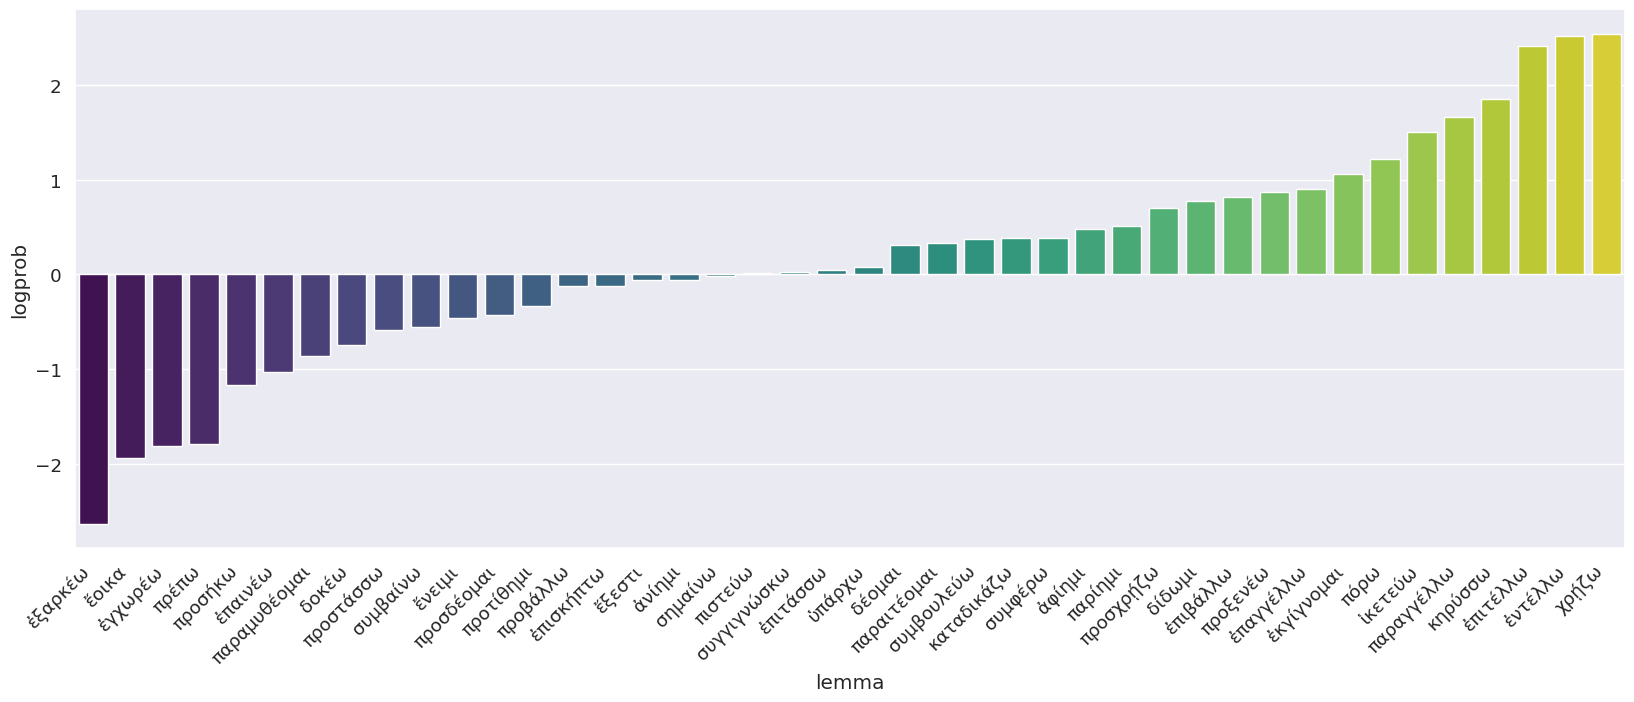

In [19]:
    plt.figure(figsize=(20, 7))
    sns.set(font_scale=1.2)

    chart = sns.barplot(
        data=diffs.sort_values("logprob"), x="lemma", y="logprob", palette="viridis"
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.savefig(
        "./figs/diff.png", bbox_inches="tight"
    )

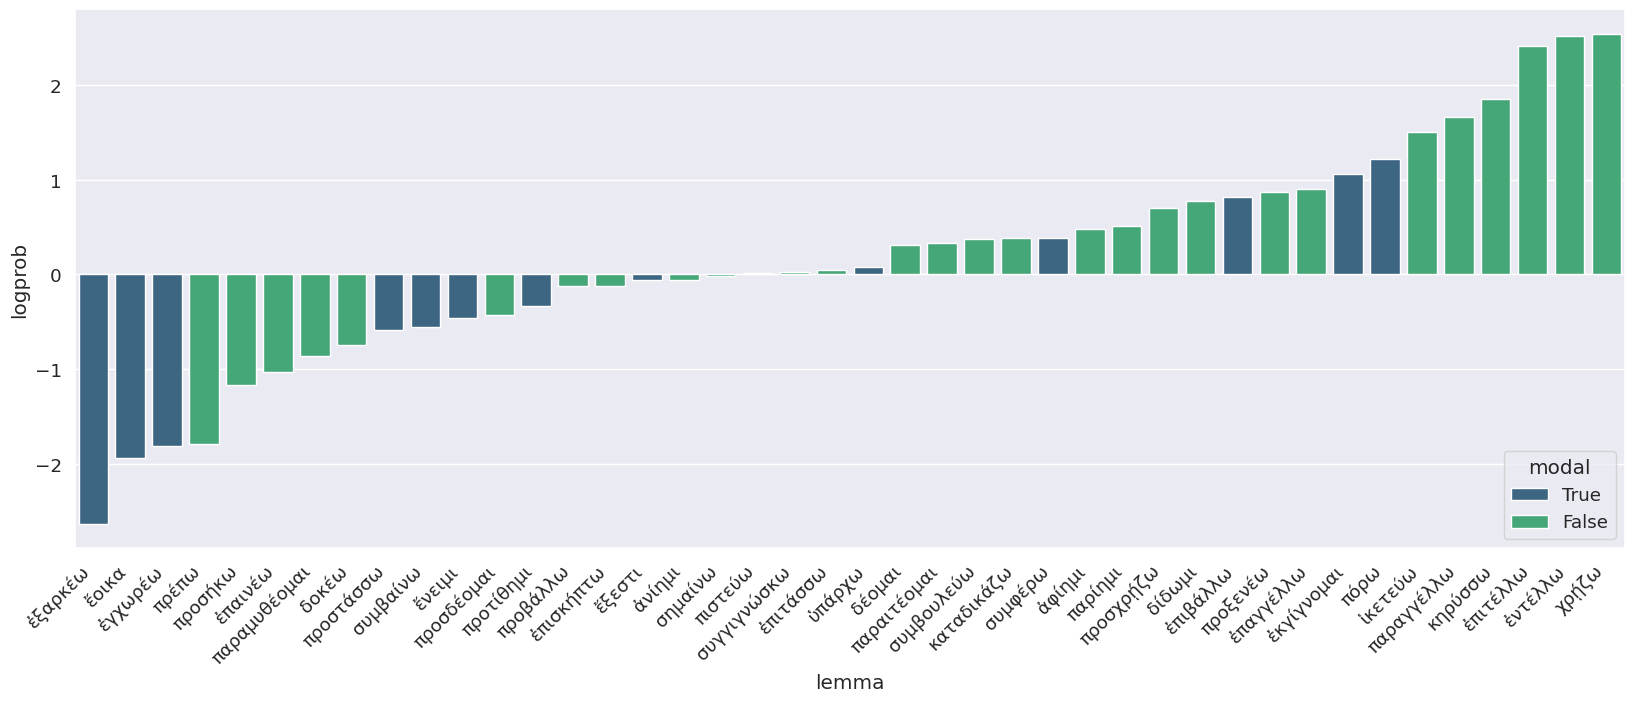

In [24]:
plt.figure(figsize=(20, 7))
sns.set(font_scale=1.2)

diffs["modal"] = diffs["modal"].astype("str")

chart = sns.barplot(
        data=diffs.sort_values("logprob"),
        x="lemma",
        y="logprob",
        hue="modal",
        dodge=False,
        palette="viridis")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.savefig(
        "/home/caiog/proj/2023sbec/fala/figs/diff2.png", bbox_inches="tight"
    )

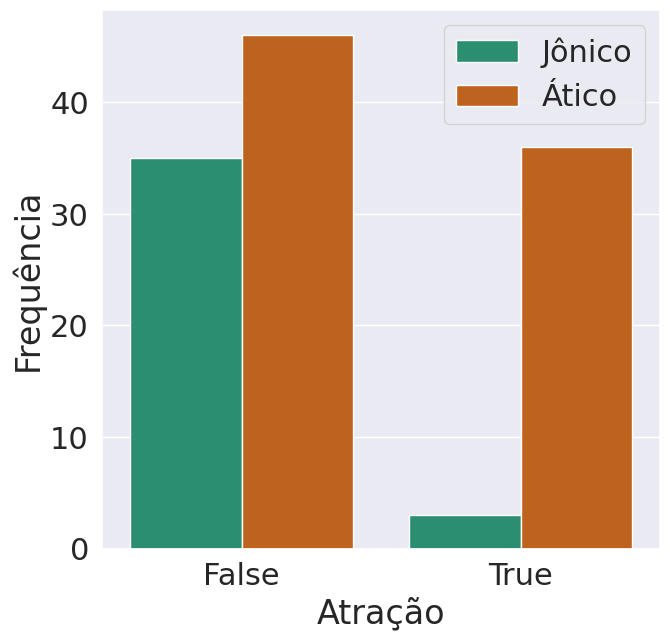

In [21]:
df_mestrado = pd.read_csv(
        "/home/caiog/proj/data/master-data/data.csv")

sns.set(font_scale=2)
plt.figure(figsize=(7.2, 7))
sns.countplot(
        data=df_mestrado, x="attraction", hue="dialect_attic", palette="Dark2"
)
plt.xlabel("Atração")
plt.ylabel("Frequência")
plt.legend(["Jônico", "Ático"])
plt.savefig(
        fname="./figs/dialeto.png")

ValueError: Could not interpret input 'poss_verb'

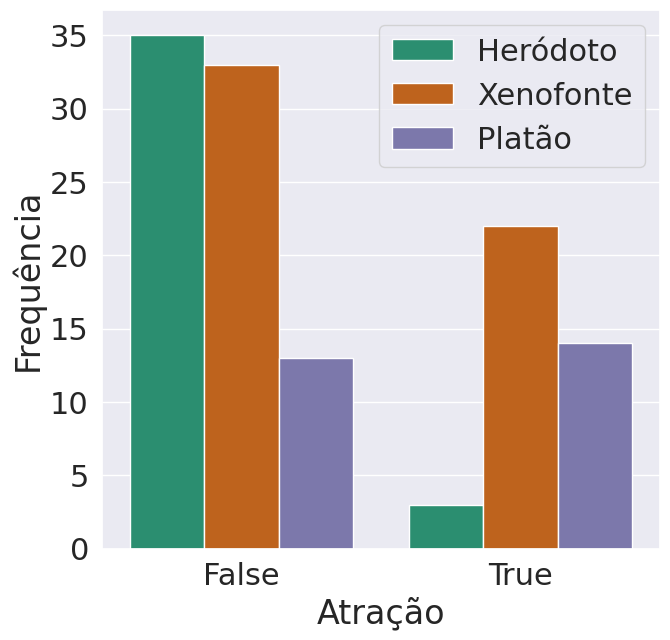

<Figure size 720x700 with 0 Axes>

In [22]:
    plt.figure(figsize=(7.2, 7))
    sns.countplot(
        data=df_mestrado,
        x="attraction",
        hue="author",
        hue_order=["Herodotus", "Xenophon", "Plato"],
        palette="Dark2",
    )
    plt.xlabel("Atração")
    plt.ylabel("Frequência")
    plt.legend(["Heródoto", "Xenofonte", "Platão"])
    plt.savefig(fname="./figs/autor.png")

    plt.figure(figsize=(7.2, 7))
    sns.countplot(data=df_mestrado, x="attraction",
                  hue="poss_verb", palette="Dark2")
    plt.xlabel("Atração")
    plt.ylabel("Frequência")
    plt.legend(["Não-modal", "Modal"])
    plt.savefig(fname="./figs/vposs.png")

In [ ]:
    plt.figure(figsize=(7.2, 7))
    sns.countplot(
        data=df_mestrado,
        x="poss_verb",
        hue="author",
        hue_order=["Herodotus", "Xenophon", "Plato"],
        palette="Dark2",
    )
    plt.xlabel("Verbo modal")
    plt.ylabel("Frequência")
    plt.legend(["Heródoto", "Xenofonte", "Platão"])
    plt.savefig(
        fname="./figs/vposs_autor.png")

In [ ]:
    print(
        df_flp[["genero", "lemma", "logprob", "z"]]
        .groupby(["lemma", "genero"])
        .agg(lambda x: x)
    )
    logging.info(
        df_flp[["genero", "lemma", "logprob", "z"]]
        .groupby(["lemma", "genero"])
        .agg(lambda x: x)
    )
    sns.displot(diffs.z.apply(abs), kde=True,
                aspect=1.5, palette="Dark2", bins=10)
    plt.yticks(ticks=[0, 2, 4, 6, 8, 10, 12, 14])
    plt.xlabel("Diferença absoluta de z")
    plt.ylabel("Conta")
    plt.axvline(diffs.z.apply(abs).quantile(0.5), color="black")
    plt.savefig(
        "./figs/diffz.png", bbox_inches="tight"
    )